# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from scipy import stats as st
from numpy.random import RandomState

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data_0.info()
data_1.info()
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Пропуски и неверный тип значений в датасетах не обнаружены.

In [4]:
data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


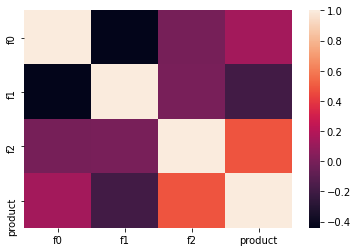

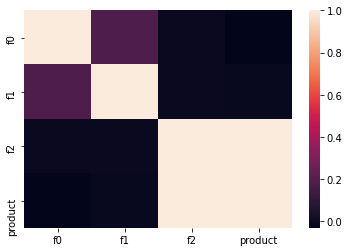

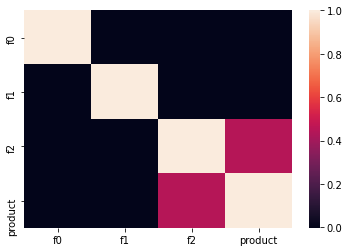

In [5]:
datasets = [data_0,data_1,data_2]

for df in datasets:
    print(df.corr())
    plt.figure()
    sns.heatmap(df.corr())

In [6]:
datasets = [data_0,data_1,data_2]

for df in datasets:
    dup = df.id.duplicated()
    print('Duplicates:',dup.sum())
    print('Id:',df[dup].id)

Duplicates: 10
Id: 7530     HZww2
41724    bxg6G
51970    A5aEY
63593    QcMuo
66136    74z30
69163    AGS9W
75715    Tdehs
90815    fiKDv
92341    TtcGQ
97785    bsk9y
Name: id, dtype: object
Duplicates: 4
Id: 41906    LHZR0
82178    bfPNe
82873    wt4Uk
84461    5ltQ6
Name: id, dtype: object
Duplicates: 4
Id: 43233    xCHr8
49564    VF7Jo
55967    KUPhW
95090    Vcm5J
Name: id, dtype: object


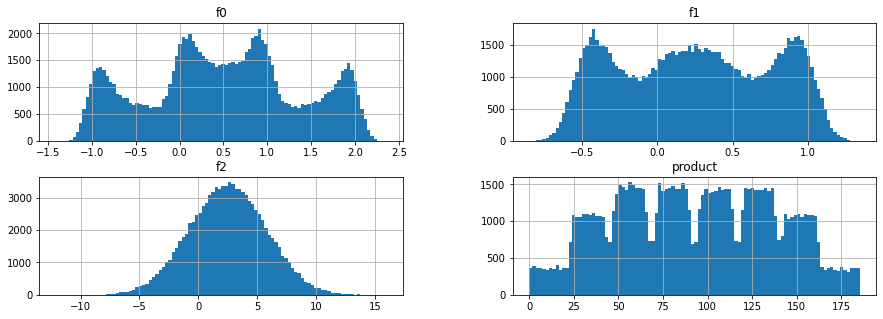

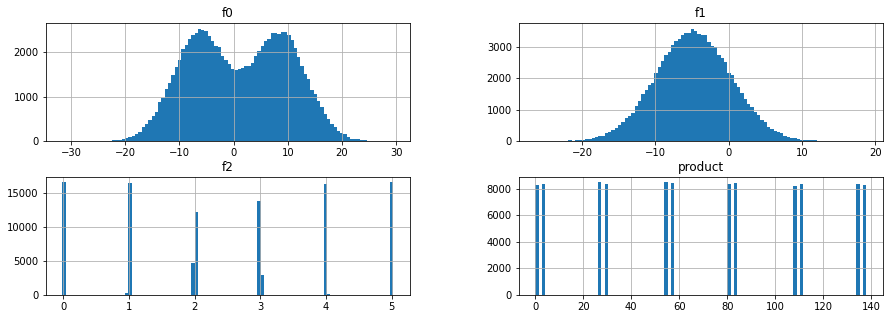

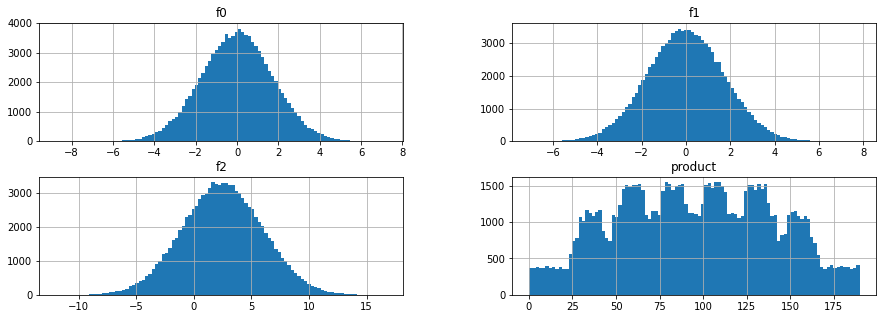

In [7]:
datasets = [data_0,data_1,data_2]

for index in range(0,3):
    datasets[index].hist(bins = 100,figsize=(15,5))

Вывод: Было загружено 3 датасета, явных дубликатов, аномальных значений и пропусков не выявлено,
    данные готовы к дальнейшему использованию.

## Обучение и проверка модели

In [8]:
def features(data):
    features = data.drop('product',axis=1)
    target = data['product']
    return features,target

In [9]:
features_0,target_0 = features(data_0)
features_1,target_1 = features(data_1)
features_2,target_2 = features(data_2)

In [10]:
def split(features,target,size):
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                      test_size = size, random_state = 12345)
    return features_train, features_valid, target_train, target_valid

In [11]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(features_0,target_0,0.25)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split(features_1,target_1,0.25)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split(features_2,target_2,0.25)

Масштабирование

In [13]:
numeric = ['f0', 'f1', 'f2']
scaler_0 = StandardScaler()
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_0.fit(features_train_0[numeric])
scaler_1.fit(features_train_1[numeric])
scaler_2.fit(features_train_2[numeric])

features_train_0[numeric] = scaler_0.transform(features_train_0[numeric])
features_train_1[numeric] = scaler_1.transform(features_train_1[numeric])
features_train_2[numeric] = scaler_2.transform(features_train_2[numeric])
features_valid_0[numeric] = scaler_0.transform(features_valid_0[numeric])
features_valid_1[numeric] = scaler_1.transform(features_valid_1[numeric])
features_valid_2[numeric] = scaler_2.transform(features_valid_2[numeric])

/tmp/ipykernel_93/2338441166.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_0[numeric] = scaler_0.transform(features_train_0[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_93/2338441166.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [14]:
features_train_0 = features_train_0.drop('id', axis=1)
features_train_1 = features_train_1.drop('id', axis=1)
features_train_2 = features_train_2.drop('id', axis=1)
features_valid_0 = features_valid_0.drop('id', axis=1)
features_valid_1 = features_valid_1.drop('id', axis=1)
features_valid_2 = features_valid_2.drop('id', axis=1)

In [16]:
features_train_0.head(5)

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865
70185,-1.837105,0.010321,-0.147634
82230,-1.299243,0.987558,1.273181


In [17]:
def LinRegression(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, prediction_valid)) ** 0.5
    r2 = r2_score(target_valid, prediction_valid)
    mae = mean_absolute_error(target_valid, prediction_valid)
    prediction_mean = pd.Series(prediction_valid).mean() 
    target_mean = pd.concat([target_valid, target_train]).mean()
    return rmse, prediction_mean, target_mean, prediction_valid


In [18]:
rmse_0, prediction_mean_0, target_mean_0, prediction_valid_0 = LinRegression(features_train_0,
                                                            target_train_0, features_valid_0, target_valid_0)
rmse_1, prediction_mean_1, target_mean_1, prediction_valid_1= LinRegression(features_train_1,
                                                            target_train_1, features_valid_1, target_valid_1)
rmse_2, prediction_mean_2, target_mean_2, prediction_valid_2 = LinRegression(features_train_2,
                                                            target_train_2, features_valid_2, target_valid_2)

In [19]:
metrics = {'rmse': [rmse_0, rmse_1, rmse_2], 
        'Средний запас_предсказание': [prediction_mean_0, prediction_mean_1, prediction_mean_2],
        'Средний запас_факт': [target_mean_0, target_mean_1, target_mean_2]
       }
metrics = pd.DataFrame(metrics)
display(metrics)

,rmse,Средний запас_предсказание,Средний запас_факт
0,37.579422,92.592568,92.500
1,0.893099,68.728547,68.825
2,40.029709,94.965046,95.000


Вывод:

Модель линейной регрессии, построенная для второго участка добычи показывает наилучшие результаты. Минимальный уровень средней добычи на данном участке 68 тыс. баррелей.

Модели для первого и третьего участка показывают схожие результаты среднеквадратичной ошибки и среднего уровня добычи в 92-95 тыс. баррелей.

## Подготовка к расчёту прибыли

Условия задачи

In [20]:
budget = 10000000000   #Бюджет 
total_holes = 500 #Кол-во исследуемых скважин
best_holes = 200  # Кол-во лучших скважин
profit_from_hole = 450000   #Доход с единицы продукта

Рассчитем объём сырья достаточный для безубыточной разработки скважины

In [21]:
profit = budget / best_holes / profit_from_hole
print('Объём сырья достаточный для безубыточной разработки скважины:',round(profit),'тыс.баррелей')

Объём сырья достаточный для безубыточной разработки скважины: 111 тыс.баррелей


111 тыс. баррелей - это минимальный объём сырья для безубыточной разработки скважины. Сравним это с полученными ранее средними значениями запаса нефти в скважине.

In [22]:
display(metrics)

,rmse,Средний запас_предсказание,Средний запас_факт
0,37.579422,92.592568,92.500
1,0.893099,68.728547,68.825
2,40.029709,94.965046,95.000


Вывод:

Средний уровень запасов не удовлетворяет минимальному объёму сырья.

In [36]:
prediction_valid_0 = pd.Series(prediction_valid_0)
prediction_valid_1 = pd.Series(prediction_valid_1)
prediction_valid_2 = pd.Series(prediction_valid_2)

target_valid_0 = target_valid_0.reset_index(drop = True)
target_valid_1 = target_valid_1.reset_index(drop = True)
target_valid_2 = target_valid_2.reset_index(drop = True)

In [54]:


def profit_holes(prediction_valid, target_valid, profit_from_hole, best_holes, budget):
    target_valid = target_valid.reset_index(drop=True)
    prediction_valid = prediction_valid.reset_index(drop=True)
    prediction_valid_sorted = prediction_valid.sort_values(ascending = False)
    target_valid_sorted = target_valid[prediction_valid_sorted.index][:best_holes]


    # КОД РЕВЬЮЕРА, debug
    if sorted(prediction_valid_sorted.index[:200]) != sorted(target_valid_sorted.index):
        print("Index Error!")
    if target_valid[prediction_valid_sorted.index].shape[0] > prediction_valid_sorted.shape[0]:
        print("Shape Mismatch! Targets shape:", target_valid[prediction_valid_sorted.index].shape)


    return target_valid_sorted.sum() * profit_from_hole - budget  


In [55]:
# КОД РЕВЬЮЕРА
_preds = pd.Series([1, 2, 2, 5, 5], index=[0, 1, 1, 3, 3])
_target = pd.Series([1, 2, 2, 5, 5], index=[0, 1, 1, 3, 3])

_target.loc[_preds.index]

0    1
1    2
1    2
1    2
1    2
3    5
3    5
3    5
3    5
dtype: int64

In [56]:
print('Прибыль 1-го региона :',(profit_holes(prediction_valid_0, target_valid_0,
                                    profit_from_hole, best_holes, budget)/1000000000).round(2),'млрд р')
print('Прибыль 2-го региона :',(profit_holes(prediction_valid_1, target_valid_1,
                                    profit_from_hole, best_holes, budget)/1000000000).round(2),'млрд р')
print('Прибыль 3-го региона :',(profit_holes(prediction_valid_2, target_valid_2,
                                    profit_from_hole, best_holes, budget)/1000000000).round(2),'млрд р')

Прибыль 1-го региона : 3.32 млрд р
Прибыль 2-го региона : 2.42 млрд р
Прибыль 3-го региона : 2.71 млрд р


Вывод

Наибольшая прибыль в регионе 1

## Расчёт прибыли и рисков 

In [57]:
state = RandomState(12345) 

boot_targets = [target_valid_0, target_valid_1, target_valid_2]
boot_predicts = [prediction_valid_0, prediction_valid_1, prediction_valid_2]


values = []

for region in range(3):
    for i in range(1000):
        target_subsample = boot_targets[region].sample(n=500, replace=True, random_state=state)  
        probs_subsample = boot_predicts[region][target_subsample.index]
        values.append(profit_holes(probs_subsample, target_subsample, profit_from_hole, best_holes, budget)) 

    values = pd.Series(values)
    lower = values.quantile(0.5)
    confidence_interval = (values.quantile(0.025), values.quantile(0.975))
    
    mean = values.mean()
    
    negativ_count = values[values < 0].count()
    print()
    print()
    print("Средняя прибыль региона", region+1, ":",mean.round(), "р.")
    print("2.5%-квантиль:",lower.round(), "р.")
    print("95%-ый доверительный интервал: {:,.2f} - {:,.2f}".format(confidence_interval[0], confidence_interval[1]))
    print("Вероятность убытков: ",negativ_count / len(values)*100,'%')
    
    values = []



Средняя прибыль региона 1 : 396164985.0 р.
2.5%-квантиль: 395008856.0 р.
95%-ый доверительный интервал: -111,215,545.89 - 909,766,941.55
Вероятность убытков:  6.9 %


Средняя прибыль региона 2 : 461155817.0 р.
2.5%-квантиль: 462011936.0 р.
95%-ый доверительный интервал: 78,050,810.75 - 862,952,060.26
Вероятность убытков:  0.7000000000000001 %


Средняя прибыль региона 3 : 392950475.0 р.
2.5%-квантиль: 384655292.0 р.
95%-ый доверительный интервал: -112,227,625.38 - 934,562,914.55
Вероятность убытков:  6.5 %


Вывод

Максимальная средняя прибыль во втором регионе - 461 млн.руб. Этот регион также единственный показывает положительный 95% доверительный интервал.

Оценивая риски убытков, был рассчитан уровень риска. Регион 2 также показал минимальный уровень риска 0.7%. Остальные регионы, с уровнем риска более 6% не удовлетворяют условиям для дальнейшей разработки месторождений. 


Общий вывод

Были проанализированы 3 датасеты и на их основе обчуна модель LinearRegression, с помощью который были получены предсказания по объёму сырья.

Рассчитан минимальный уровень запаса сырья для безубыточной добычи, равный 111 тыс. барр

Определены потенциальные прибыли для каждого региона по 200 лучшим скважинам

Расчитаны средние прибыли и риски для каждого региона. Максимальную среднюю прибыль в регионе 2 - 461 млн. руб

Наименьшая вероятность убытков также в регионе 2

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован